# Baseline Solution for Predicting Olympic Medal Count
<p><c>
    <img src="images/Olympic-logo.png" alt="Olympic Logo" width=300/>
</c></p>
This notebook implements and evaluates a simple baseline predictive model to help us quantify the impact of feature engineering. This notebook is meant as a companion notebook to [FeaturetoolsPredictiveModeling.ipynb](FeaturetoolsPredictiveModeling.ipynb) which explains the concepts of feature engineering and machine learning in more depth. While the solutions here will outperform random guessing, we will see that feature engineering help us achieve significantly better results.

In [1]:
import pandas as pd
import numpy as np
import featuretools as ft
from collections import defaultdict
from sklearn.metrics import roc_auc_score
from featuretools.primitives import Count, Mean, NUnique
import os
import utils as utils

%matplotlib inline

## Load in data and labels

In [2]:
DATA_DIR = os.path.join(os.getcwd(), "data/olympic_games_data")
es = utils.load_entityset(data_dir=DATA_DIR)
label_file = os.path.join(DATA_DIR, "num_medals_by_country_labels.csv")

label_df = pd.read_csv(label_file,
                       parse_dates=['Olympics Date'],
                       usecols=['Number of Medals', 'Olympics Date', 'Country'],
                       encoding='utf-8')

label_df.sort_values(['Olympics Date', 'Country'], inplace=True)
cutoff_times = label_df[['Country', 'Olympics Date']].rename(
                   columns={'Country': 'Code'})
label_df.head()

,Number of Medals,Olympics Date,Country
8,2,1896-06-29 00:00:00,AUS
9,5,1896-06-29 00:00:00,AUT
5,6,1896-06-29 00:00:00,DEN
10,11,1896-06-29 00:00:00,FRA
4,7,1896-06-29 00:00:00,GBR


# Baseline Predict: Mean number of past medals

We will calculate the mean number of medals won by a country in the past, and use that as our prediction for the future. This solution does not use any machine learning. 

To calculate the mean number of medals, we use `Count` to find the number of medals won by a given country at the Olympic Games and then we use `Mean` to find the average. Though we've written a formula for `mean_num_medals` the feature won't actually be computed until we calculate the feature matrix below.

In [3]:
num_medals = Count(es['medals_won']['medal_id'],
                   es['countries_at_olympic_games'])

mean_num_medals = Mean(num_medals, es['countries']).rename("mean_num_medals")


## Compute features

In [4]:
feature_matrix = ft.calculate_feature_matrix([mean_num_medals],
                                             cutoff_time=cutoff_times,
                                             cutoff_time_in_index=True,
                                             verbose=True)
feature_matrix.tail()

Progress: 100%|██████████| 27/27 [00:18<00:00,  1.35s/cutoff time]


,,mean_num_medals
Code,time,
TUN,2012-06-29,1.25
TUR,2012-06-29,5.20
UKR,2012-06-29,17.00
USA,2012-06-29,71.20
UZB,2012-06-29,3.50


## How well does this predictor do?

In [5]:
# Countries that didn't take part in the previous Olympics have default nan values in the dataframe
# Set them to the mean number of medals for that year
predictions = feature_matrix.copy()
null_predictions = predictions['mean_num_medals'].isnull()
means = (predictions.groupby(level='time')['mean_num_medals'].mean().to_frame())
predictions[null_predictions] = (predictions[null_predictions].drop(['mean_num_medals'], axis=1).join(means))

# Fill the 1896 olympics with 0 since we have no data to go off of
predictions.fillna(0, inplace=True)
predictions = predictions['mean_num_medals']
predictions.head(20)

Code  time               
AUS   1896-06-29 00:00:00     0.0
AUT   1896-06-29 00:00:00     0.0
DEN   1896-06-29 00:00:00     0.0
FRA   1896-06-29 00:00:00     0.0
GBR   1896-06-29 00:00:00     0.0
GER   1896-06-29 00:00:00     0.0
GRE   1896-06-29 00:00:00     0.0
HUN   1896-06-29 00:00:00     0.0
SUI   1896-06-29 00:00:00     0.0
USA   1896-06-29 00:00:00     0.0
ZZX   1896-06-29 00:00:00     0.0
AUS   1900-06-29              2.0
AUT   1900-06-29              5.0
BEL   1900-06-29              7.4
BOH   1900-06-29              7.4
CAN   1900-06-29              7.4
CUB   1900-06-29              7.4
DEN   1900-06-29              6.0
ESP   1900-06-29              7.4
FRA   1900-06-29             11.0
Name: mean_num_medals, dtype: float64

In [6]:
y = label_df['Number of Medals'].values
y_binary = y >= 10

## Time-based cross-validation

In [7]:
splitter = utils.TimeSeriesSplitByDate(dates=label_df['Olympics Date'],
                                       earliest_date=pd.Timestamp('1/1/1960'))

X = predictions.values
binary_X = (predictions.values >= 10).astype(int)

scores_over_time = defaultdict(list)
for _, test_i in splitter.split(y=y_binary):
    predicted_binary = binary_X[test_i]
    actual_binary = y_binary[test_i]
    sfunc = roc_auc_score
    scores_over_time['roc'].append(sfunc(actual_binary, predicted_binary))
    
"Average AUC score is {} with standard dev {}".format(
        round(np.mean(scores_over_time['roc']), 3),
        round(np.std(scores_over_time['roc']), 3)
)

'Average AUC score is 0.794 with standard dev 0.045'

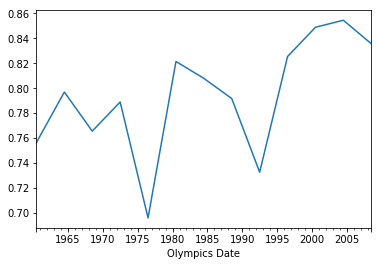

In [8]:
dates = splitter.dates.drop_duplicates()
dates = dates[dates['Olympics Date'] >= pd.Timestamp('1/1/1960')][:-1]['Olympics Date']
pd.Series(scores_over_time['roc'], index=dates).plot()

## Analysis

Our AUC of .79 (out of 1.0) is already better than randomly guessing. However, we can improve this score to .95 by performing feature engineering and applying machine learning, which we will see in the [Featuretools Predictive Modeling](PredictOlympicMedals.ipynb) notebook.

Also, looking at the graph of scores over time, it seems our average gets better over time, albeit with large spikes for certain years. That trend will also continue into the results section of the other notebook.

<p>
    <img src="https://www.featurelabs.com/img/logo.png" alt="Featuretools" />
</p>


Featuretools was created by the developers at [Feature Labs](https://www.featurelabs.com/). If building impactful data science pipelines is important to you or your business, please [get in touch](https://www.featurelabs.com/contact.html).